In [1]:
%load_ext autoreload
%autoreload 2


import torch
import torchvision

import cv2
import matplotlib.pyplot as plt
import textwrap
import os

from data.DownloadData import load_meta
from data.LoadData import ImageCaptionDataset, String2Int
from models import ShowAttendTell

#http://proceedings.mlr.press/v37/xuc15.pdf

In [3]:
train_meta = load_meta("./data/metadata/train_meta.json")
valid_meta = load_meta('./data/metadata/valid_meta.json')

train_paths = ['./data'+path for path in train_meta['paths']]
valid_paths = ['./data'+path for path in valid_meta['paths']]

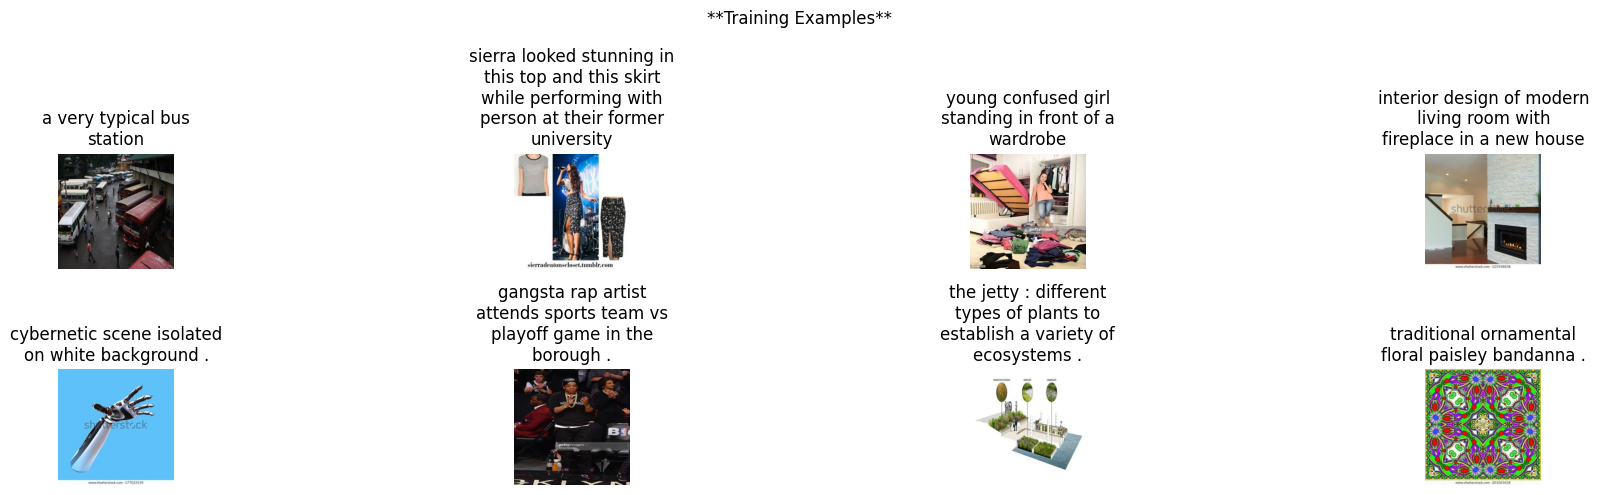

In [4]:
fig, axes = plt.subplots(2, 4, figsize=(20,5))

for i, ax in enumerate(axes.flat):
    img = cv2.imread(train_paths[i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    ax.imshow(img)
    ax.set_title('\n'.join(textwrap.wrap(train_meta['labels'][i], width=25)))
    ax.axis('off')
fig.suptitle("**Training Examples**")
fig.tight_layout()

In [6]:
remove_punct = '<>'
start_token = '<sos>'
stop_token = '<eos>'
pad_token = '<pad>'

stoi_config = String2Int(train_meta['labels']+valid_meta['labels'],
                        start_token=start_token, stop_token=stop_token, pad_token=pad_token,
                        remove_punct=remove_punct
)

vocab_size = len(stoi_config)
longest_caption = len(max([line.split() for line in train_meta['labels']], key=len))
print(f"{vocab_size = }")
print(f"{longest_caption = }")

vocab_size = 4248
longest_caption = 41


In [7]:
vocab_size = len(stoi_config)
longest_caption = len(max([line.split() for line in train_meta['labels']], key=len))
print(f"{vocab_size = }")
print(f"{longest_caption = }")

vocab_size = 4248
longest_caption = 41


In [10]:
train_dataset = ImageCaptionDataset(X_paths=train_paths,
                                    y_labels=train_meta['labels'],
                                    string2int=stoi_config)

valid_dataset = ImageCaptionDataset(X_paths=valid_paths, 
                                    y_labels=valid_meta['labels'],
                                    string2int=stoi_config)

In [11]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=12, shuffle=False, drop_last=True) #shuffle to True to reshuffle the data at every epoch

x, y = next(iter(train_dataloader))
print(f"{x.shape = }")
print(f"{y.shape = }")

x.shape = torch.Size([12, 3, 256, 256])
y.shape = torch.Size([12, 43])


In [13]:
%autoreload 2

encoder = ShowAttendTell.Encoder()
decoder = ShowAttendTell.Decoder(embed_dim=11, dec_hidden_dim=64, attention_dim=50, string2int=stoi_config)


encoder_out = encoder(x)
encoder_out = encoder_out.view(12, -1, 2048)
predictions, alphas, decode_len = decoder(encoder_out, y)

In [14]:
predictions.shape

torch.Size([12, 18, 4248])